# CNN Autoencoders with Encodec

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
import random
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import sys
sys.path.append("../..")
print(sys.path)
from dataset_generation.randomDataset import RandomDataset
from utils.numpyDataset import NumpyDataset
from utils.cnn import CNNNetwork

from torch import nn
from torch.nn import functional as F

['/home/dylangoetting/voculator/autoencoder/lstm', '/home/dylangoetting/miniconda3/envs/venv/lib/python38.zip', '/home/dylangoetting/miniconda3/envs/venv/lib/python3.8', '/home/dylangoetting/miniconda3/envs/venv/lib/python3.8/lib-dynload', '', '/home/dylangoetting/miniconda3/envs/venv/lib/python3.8/site-packages', '..', '../..', '..', '../..']


In [72]:
from torch import nn
import torch


class CNNNetwork(nn.Module):

    def __init__(self, out_neurons, input_shape, layers=None, kernel=3, stride=1, padding=2):
        super().__init__()
        assert len(input_shape) == 3
        c, h, w = input_shape
        self.layers = [c] + layers if layers else [c, 16, 32, 64, 128]
        self.out_neurons = out_neurons
        self.verbose = True
        # 4 conv blocks / flatten / linear / softmax
        self.conv_layers = []
        self.kernel_size = kernel
        for i in range(len(self.layers) - 1):
            subm = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.layers[i],
                    out_channels=self.layers[i+1],
                    kernel_size=kernel,
                    stride=stride,
                    padding=padding
                ),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            )
            self.add_module(f'conv_layer{i}', subm)
            self.conv_layers.append(subm)

        self.flatten = nn.Flatten()
        for i in range(len(self.layers)-1):
            layer = self.conv_layers[i][0]
            h = (h + 2*layer.padding[0] - layer.dilation[0] *
                 (layer.kernel_size[0] - 1) - 1)/layer.stride[0] + 1
            w = (w + 2*layer.padding[1] - layer.dilation[1] *
                 (layer.kernel_size[1] - 1) - 1)/layer.stride[1] + 1
        linear_in = int(self.layers[-1]*h*w)
        print(linear_in)
        #self.linear = nn.Linear(linear_in, self.out_neurons)
        #self.linear = nn.Linear(3456, self.out_neurons)
        self.linear = None
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = input_data
        if self.verbose:
            print(x.shape)
        for conv in self.conv_layers:
            x = conv(x)
            if self.verbose:
                print(x.shape)

        x = self.flatten(x)
        if self.linear is None:
            self.linear = nn.Linear(x.shape[1], self.out_neurons)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        self.verbose = False
        return predictions

In [73]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim

        self.fc = nn.Linear(embedding_dim, 64 * 4 * 131)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), output_padding=(0, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(0, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 4, 131)
        x = self.decoder(x)
        return x

class CNNAutoencoder(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNAutoencoder, self).__init__()
        
        self.encoder = CNNNetwork(out_neurons=embedding_dim, input_shape=(1, 8, 525), layers=[8, 16, 32], kernel=(3,3), stride=(1, 2))
        self.decoder = Decoder(embedding_dim)
        
    def forward(self, x):
        
        x = self.encoder(x)
        return self.decoder(x)
    
model = CNNAutoencoder(64)
input = torch.rand(64, 1, 8, 525)
print(model(input).shape)

30576
torch.Size([64, 1, 8, 525])
torch.Size([64, 8, 5, 132])
torch.Size([64, 16, 3, 33])
torch.Size([64, 32, 2, 9])
torch.Size([64, 1, 8, 525])


In [74]:

dataset = NumpyDataset('../../dataset_generation/trainX_denoised_8.npy', '../../dataset_generation/trainY_denoised_8.npy')
train_data, val_data = random_split(dataset=dataset, lengths=[0.7, 0.3])
train_dl, val_dl = DataLoader(train_data, batch_size=64), DataLoader(val_data, batch_size=64)

In [6]:
for i in range(3):
    X_val, y_val = train_data[i]
    print(X_val)
    print(y_val)

[[0.2109375  0.2109375  0.39257812 ... 0.02246094 0.3154297  0.8144531 ]
 [0.8144531  0.17089844 0.6796875  ... 0.63183594 0.40429688 0.39453125]
 [0.14941406 0.5517578  0.07324219 ... 0.4892578  0.41796875 0.94433594]
 ...
 [0.58203125 0.4033203  0.3984375  ... 0.8984375  0.7451172  0.55371094]
 [0.66796875 0.4189453  0.3486328  ... 0.3515625  0.6748047  0.4736328 ]
 [0.42871094 0.11523438 0.99609375 ... 0.9941406  0.7792969  0.60253906]]
0
[[0.7207031  0.99316406 0.10351562 ... 0.9121094  0.7998047  0.7998047 ]
 [0.82128906 0.89160156 0.29492188 ... 0.44726562 0.9482422  0.27539062]
 [0.9658203  0.8017578  0.03515625 ... 0.5761719  0.7939453  0.7939453 ]
 ...
 [0.6669922  0.00976562 0.86035156 ... 0.7626953  0.4873047  0.609375  ]
 [0.73046875 0.99121094 0.5566406  ... 0.57128906 0.11132812 0.37109375]
 [0.5761719  0.38378906 0.95214844 ... 0.328125   0.8496094  0.6542969 ]]
6
[[0.02441406 0.5517578  0.9511719  ... 0.73535156 0.1875     0.1875    ]
 [0.8466797  0.65722656 0.20898438 

In [75]:
train_data[0][0].shape

(8, 525)

In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.MSELoss()

seq_len = train_data[0][0].shape[1]
no_features = train_data[0][0].shape[0]
#model = CNNAutoencoder(64)
#model(torch.rand(64, 1, 8, 525))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

cuda


In [90]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        # disregard labels for autoencoder reconstruction loss

        input = input.unsqueeze(1)
        # input dimensions for LSTMs: (batch_size, length, n_dim)
        input = (input - input.mean()) / input.std()
        input = input.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, input)
        losses.append(loss.item())

        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        opt.step()
    
    metrics['t_loss'].append((sum(losses)/len(losses)))
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        
        input = input.unsqueeze(1)
        input = (input - input.mean()) / input.std()
        input, target = input.to(device), target.to(device)
        prediction = model(input)

        loss = loss_fn(prediction, input)
        losses.append(loss.item())
    
    metrics['v_loss'].append((sum(losses)/len(losses)))

In [93]:
metrics = {
    't_loss': [],
    'v_loss': [],
}
print('****** STARTING TRAINING ******')
for epoch in range(100):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch}; Training loss: {metrics['t_loss'][-1]}; Validation loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

****** STARTING TRAINING ******
Finished epoch: 0; Training loss: 0.989506083173476; Validation loss: 0.9882443667726314
Finished epoch: 1; Training loss: 0.9878552147786911; Validation loss: 0.9875755119831005
Finished epoch: 2; Training loss: 0.9877697349139; Validation loss: 0.987552154360088
Finished epoch: 3; Training loss: 0.9877196374367724; Validation loss: 0.9874993814221511
Finished epoch: 4; Training loss: 0.9876974924514282; Validation loss: 0.9875652950706212
Finished epoch: 5; Training loss: 0.9876727828333548; Validation loss: 0.9875119434180835
Finished epoch: 6; Training loss: 0.9876655286668461; Validation loss: 0.9874626231108997
Finished epoch: 7; Training loss: 0.9876627942017043; Validation loss: 0.9874596137104305


KeyboardInterrupt: 

## Visualize reconstruction

torch.Size([1, 8, 525])
torch.Size([1, 8, 525])


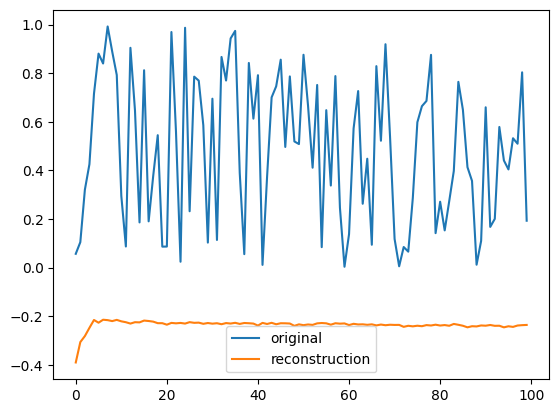

In [94]:
test = dataset[510:511][0]
test = torch.tensor(test)
test = (test - test.mean()) / test.std()
model.cpu()
r = torch.rand(1, 8, 525)
print(r.shape)
rc = model(r.unsqueeze(0))[0]
print(rc.shape)
plt.plot(r[0, 0, 0:100])
plt.plot(rc.detach()[0, 0, 0:100])
plt.legend(['original', 'reconstruction'])

In [85]:
from utils.codec import CodecTransform
transform = CodecTransform(sample_rate=16000, bandwidth=6.0).cpu()

pred = (rc * test.std()) + test.mean()
pred = torch.clamp(pred, min=0, max=1023/1024)
wav = transform.decode(pred.cpu())
IPython.display.Audio(wav, rate=24000)

In [88]:
torchaudio.save('test_2.wav', wav, 24000)